In [108]:
import reading
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, InputLayer, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv3D, AveragePooling2D, AveragePooling3D, MaxPooling2D, MaxPooling3D, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
dataset = pd.read_csv('ADNI_dataset_diffusion.csv')
dataset["Path"] = reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001", "corrected_FA_image")
print(dataset)

    Subject  Group  Sex   Age  \
0      4081      0    F  73.0   
1      4119      0    M  79.0   
2      4136      1    M  67.0   
3      4142      1    F  90.0   
4      4152      1    M  61.0   
..      ...    ...  ...   ...   
92     5095      1    M  66.0   
93     4369      0    M  68.0   
94     4371      0    M  68.0   
95     4396      0    F  78.0   
96     4422      0  NaN   NaN   

                                                 Path  
0   Diffusion_parameters_maps-20230215T134959Z-001...  
1   Diffusion_parameters_maps-20230215T134959Z-001...  
2   Diffusion_parameters_maps-20230215T134959Z-001...  
3   Diffusion_parameters_maps-20230215T134959Z-001...  
4   Diffusion_parameters_maps-20230215T134959Z-001...  
..                                                ...  
92  Diffusion_parameters_maps-20230215T134959Z-001...  
93  Diffusion_parameters_maps-20230215T134959Z-001...  
94  Diffusion_parameters_maps-20230215T134959Z-001...  
95  Diffusion_parameters_maps-20230215T1349

In [26]:
images_list = []
for i, datapath in enumerate(dataset["Path"]):
    image = np.asarray(nib.load(datapath).get_fdata())
    #image[image == 0] = float('NaN')
    images_list.append(image)
    
images = np.array(images_list, dtype='float64')
labels = np.array(dataset["Group"], dtype='int64')



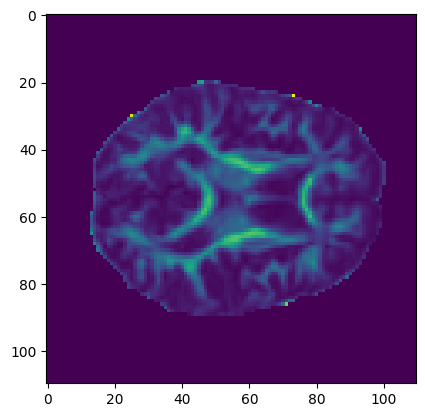

In [45]:
plt.imshow(images[90,:,:,56])

In [104]:
def split_2D():
    X_train, x_test, Y_train, y_test = train_test_split(images[:,:,:,53:56], labels, test_size=0.1, random_state=1)
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=97)
    return x_train, y_train, x_val, y_val, x_test, y_test

def split_3D():
    X_train, x_test, Y_train, y_test = train_test_split(images[:,:,:,53:56], labels, test_size=0.2, random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [105]:
x_train, y_train, x_val, y_val, x_test, y_test = split_2D()
print(x_train.shape)

(78, 110, 110, 3)


In [29]:
def make_3D_CNN(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv3D(2, (11,11,1), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      AveragePooling3D((2,2,1), strides=2),
      #Dropout(0.4),

      Conv3D(4, (11,11,1), padding='valid'),
      BatchNormalization(),
      Activation('relu'),,kernel_regularizer='l2',bias_regularizer='l1'

      AveragePooling3D((2,2,1), strides=2),
      #Dropout(0.4),
      
      Conv3D(8, (11,11,1), padding='valid'),
      BatchNormalization(),
      Activation('relu'),

      AveragePooling3D((2,2,1), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(10, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
     
  ])
  return model

SyntaxError: invalid syntax (3788359525.py, line 13)

In [50]:
def make_2D_CNN_best(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),110
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(20, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

DATA AUGMENTATION


In [115]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(110,110)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [127]:
def make_2D_CNN(shape=(110, 110, 3)):
  model = Sequential([
    
    
      layers.RandomFlip(mode="horizontal_and_vertical", input_shape=shape),
      
      layers.RandomFlip(mode="horizontal_and_vertical", input_shape=shape),

      
      layers.RandomRotation(factor=(-0.5,0.5),fill_mode="reflect",interpolation="bilinear",fill_value=0,input_shape=shape),
      
      layers.RandomRotation(factor=(-0.5,0.5),fill_mode="reflect",interpolation="bilinear",fill_value=0,input_shape=shape),


      
      Conv2D(8, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),110
      
      Conv2D(32, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(64, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(20, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [128]:
model = make_2D_CNN()
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 110, 110, 3)       0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 110, 110, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 110, 110, 3)      0         
 tation)                                                         
                                                                 
 random_rotation_9 (RandomRo  (None, 110, 110, 3)      0         
 tation)                                                         
                                                                 
 conv2d_66 (Conv2D)          (None, 106, 106, 8)       608       
                                                                 
 batch_normalization_66 (Bat  (None, 106, 106, 8)    

In [129]:
model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=10)

In [131]:

epochs= 1000
batch_size = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = round(len(x_train)/batch_size),
                    verbose=1,
                    validation_data=(x_val, y_val),
                    validation_steps=round(len(x_val)/batch_size),
                    callbacks=[reduce_on_plateau, early_stopping])

Epoch 1/1000
4/4 [==============================] - 5s 117ms/step - loss: 5.4907 - accuracy: 0.5897 - lr: 0.1000
Epoch 2/1000
4/4 [==============================] - 0s 106ms/step - loss: 1.6322 - accuracy: 0.5385 - lr: 0.1000
Epoch 3/1000
4/4 [==============================] - 0s 110ms/step - loss: 0.8338 - accuracy: 0.4359 - lr: 0.1000
Epoch 4/1000
4/4 [==============================] - 0s 107ms/step - loss: 0.7585 - accuracy: 0.4744 - lr: 0.1000
Epoch 5/1000
4/4 [==============================] - 0s 108ms/step - loss: 0.7151 - accuracy: 0.4359 - lr: 0.1000
Epoch 6/1000
4/4 [==============================] - 0s 104ms/step - loss: 0.6878 - accuracy: 0.5256 - lr: 0.1000
Epoch 7/1000
4/4 [==============================] - 0s 108ms/step - loss: 0.6943 - accuracy: 0.5513 - lr: 0.1000
Epoch 8/1000
4/4 [==============================] - 0s 109ms/step - loss: 0.6869 - accuracy: 0.5513 - lr: 0.1000
Epoch 9/1000
4/4 [==============================] - 0s 119ms/step - loss: 0.6886 - accuracy: 0.5

KeyboardInterrupt: 

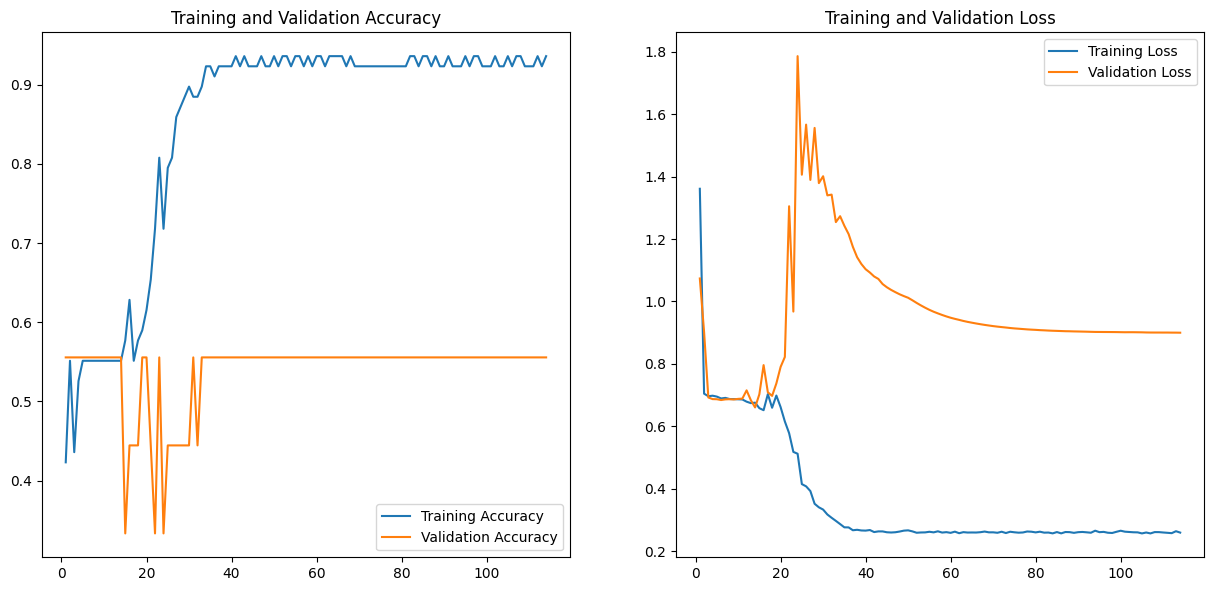

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.556
1/1 [==============================] - 0s 76ms/step
AUC = 0.550


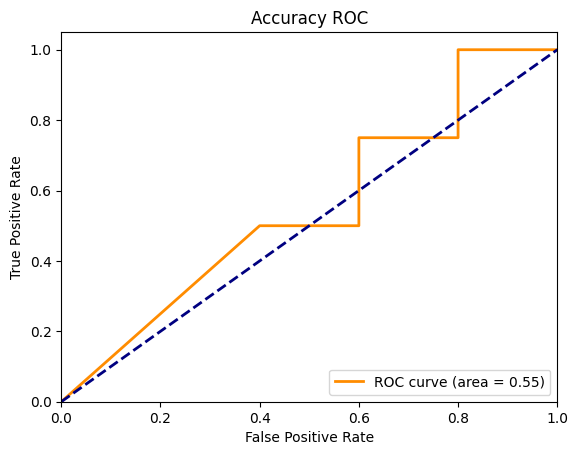

In [90]:
_, val_acc = model.evaluate(x_val, y_val, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model.predict(x_val, verbose=1)
#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy ROC')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 25ms/step - loss: 2.7668 - accuracy: 0.2000

Test accuracy: 0.200
1/1 [==============================] - 0s 28ms/step
AUC = 0.156


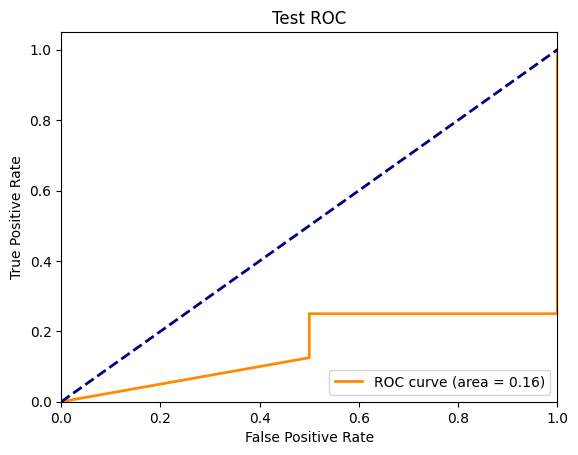

In [91]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy: %.3f' % (test_acc))

preds_test = model.predict(x_test, verbose=1)
fpr, tpr, _ = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()